<a href="https://colab.research.google.com/github/bettytan123/medical-data/blob/main/Text_Miningg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.image as mpimg
import seaborn as sns
from textblob import TextBlob
from  sklearn.feature_extraction.text import CountVectorizer
import pdb
from nltk.stem import *
from nltk.corpus import stopwords
import re
import string
from collections import Counter
from gensim import matutils, models
import scipy.sparse
from sklearn.feature_extraction import text
from wordcloud import WordCloud

https://www.kaggle.com/code/sirrknight/text-analysis-on-customer-s-comment-on-efficacy
in cooperate the code from the kaggle dataset test.csv


# UNDERSTNAD data

In [30]:
df1 = pd.read_csv('/content/drugsComTest_raw.csv', delimiter=',')
df1.dataframeName = 'drugsComTest_raw.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 53766 rows and 7 columns


In [31]:
df1.head(5)

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


In [32]:
df1.shape

(53766, 7)

<ipython-input-33-3ab4bd72a0fd>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(df1.corr())


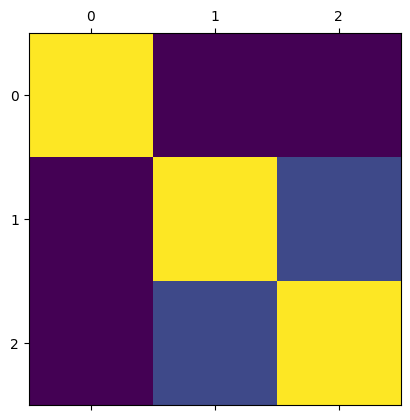

In [33]:
#correlation
#plotCorrelationMatrix(df1, 8)

plt.matshow(df1.corr())
plt.show()

# clean the data


In [34]:
def firstCleaning(data):

    """
    creates a dataframe with a summarised version of the data
    by combining ALL the reviews for ALL customers for A
    particular drugName under A particular medical condition.



    Parameters
    ----------
    data : dataframe

    output>>dataframe[drugName,condition,chunk(combination of reviews),usefulTo,averageRating]
    -------

    """
    variable = list(data.condition.unique())
    #dummydata = np.zeros((len(variable),))
    conditionList =[]
    drugnameList=[]
    chunkList=[]
    ratingList=[]
    usefulCountList=[]
    #iterating through a condition
    for i in range(len(variable)):
        conditionVariable= data0.loc[data0['condition']==variable[i]]
        #iterating through each drug in the condition
        for t in list(conditionVariable.drugName.unique()):
            drugname = conditionVariable.loc[conditionVariable['drugName']==t]
            rating = data.rating[(data.drugName==t) & (data.condition ==variable[i])].mean()
            usefulcount = data.usefulCount[(data.drugName==t) & (data.condition ==variable[i])].sum()
            #appending each review of each drug under one condition into one big chunk of text
            chunk = ''.join(drugname.review)
            #Storing my data into a list and then a dictionary for my dataframe
            conditionList.append(variable[i])
            drugnameList.append(t)
            chunkList.append(chunk)
            ratingList.append(round(rating,2))
            usefulCountList.append(usefulcount)
    final_dict ={"Condition":conditionList,"drugName":drugnameList,"chunk":chunkList,"averageRating":ratingList,"usefulTo":usefulCountList}
    final = pd.DataFrame(final_dict)
    return(final)

In [35]:
def secondCleaning(data):

    """


    Parameters
    ----------
    data : works on the chunk aspect of the dataframe and
          converts all text to lower cases, removes string
          formatting and all punctuation stored
          input>>dataframe
    Returns
    -------
    output>>series[chunk]
    Note: this should be applied on the data

    """
    clean = data.chunk
    clean = clean.str.lower()
    ##pdb.set_trace()
    clean = clean.str.replace('\[.,*?\]', '')
    clean = clean.str.replace('\w*\d\w*', '')
    clean = clean.str.replace('[%s]' % re.escape(string.punctuation), '')
    clean = clean.str.replace('\n','')
    clean = clean.str.replace('[‘’“”…]', '')
    return clean



In [36]:
#Just stemmer or lemmatizer is good for the job i implemented both to confirm if there was any significant difference between both so any should do just fine

stemmer = PorterStemmer()
def word_stemmer(text):
    """
    Parameters
    ----------
    text : built on the stemmer function to cut words into short
             forms which is not necceasarily an english word
             input>>series[chunk]


    Returns
    -------
    stem_text : output>>series[chunk] less words taken out

    """
    stem_text = "".join([stemmer.stem(i) for i in text])
    return stem_text

lemmatizer = WordNetLemmatizer()
def word_lemmatizer(text):
    """


    Parameters
    ----------
    text : built on the lemmatizer function to cut words into short
             forms which is an english word but has tradeoff which involves
             computational expenses
             input>>series[chunk]


    Returns
    -------
    lem_text : series[chunk] less words taken out

    """
    lem_text = "".join([lemmatizer.lemmatize(i) for i in text])
    return lem_text

In [37]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

In [76]:
def finalCleaning(data,stopword):
    """


    Parameters
    ----------
    data : this converts the chunk data from the corpus
    format to the document matrix format(spreading
    out the words into columns across the observation)
    input>>dataframe



    Returns
    -------
    data_dtm : dataframe[each word as a column](with multiIndexing)

        DESCRIPTION.

    """
    cv = CountVectorizer(stop_words=stopword)
    #temp=["0"] * len(data.chunk)

    #for i in range(len(data.chunk)):
    data_cv = cv.fit_transform(data.chunk)
        #temp[i]= data_cv

    data_dtm =pd.DataFrame(data_cv.toarray(),columns=cv.get_feature_names_out())
    #w = model.get_feature_names_out()
    data_info = data[['Condition','drugName']]
    #data_merged = pd.concat([data_info,test],axis=1)

    data_dtm.index = pd.MultiIndex.from_frame(data_info)
    return data_dtm

In [39]:
data0=df1

In [40]:
#Applying and visualizing the first cleaned data
combined_data = firstCleaning(data0)
combined_data.head(10)

,Condition,drugName,chunk,averageRating,usefulTo
0,Depression,Mirtazapine,"""I&#039;ve tried a few antidepressants over th...",7.59,3694
1,Depression,Escitalopram,"""I am a 22 year old female college student. I ...",7.41,4938
2,Depression,Zoloft,"""Zoloft did not help me at all. I was on it f...",6.91,7747
3,Depression,Effexor XR,"""Sadly only lasted 5 days on Effexor XR. The s...",6.77,1918
4,Depression,Venlafaxine,"""I was first prescribed Effexor 13 years ago a...",6.74,4731
5,Depression,Bupropion,"""Started taking it and I slept well at night a...",7.46,10576
6,Depression,Desvenlafaxine,"""Have developed visual problems, thinning hair...",6.97,6202
7,Depression,Sertraline,"""I&#039;ve had depression on and off for years...",7.08,12828
8,Depression,Pristiq,"""I am a 47 yo male who has been on 100mg of Pr...",7.26,6985
9,Depression,Vilazodone,"""Have been on this almost 2 weeks. It&#039;s s...",7.05,5515


In [41]:
#bottom 10 rows
combined_data.tail(10)

,Condition,drugName,chunk,averageRating,usefulTo
5551,35</span> users found this comment helpful.,Namenda,"""I have MS and NAMENDA has improved my cogniti...",10.0,35
5552,105</span> users found this comment helpful.,Viagra,"""This is a miracle drug. I have diabetes and h...",10.0,105
5553,"Herpes Simplex, Mucocutaneous/Immunocompromise...",Valacyclovir,"""I am on a regimen program of Valtrex and I ta...",10.0,42
5554,actor IX Deficiency,Cyklokapron,"""I suffer Acquired Angioedema. Ir&#039;s excel...",9.0,10
5555,Ichthyosis,Ammonium lactate,"""Not strong enough for me. Had to use the Lac-...",3.0,15
5556,29</span> users found this comment helpful.,Wellbutrin XL,"""Debated long and hard, but finally asked my O...",9.0,29
5557,Anaplastic Astrocytoma,Temodar,"""I had taken temodar for anaplastic astrocytom...",1.0,1
5558,Acute Nonlymphocytic Leukemia,Accutane,"""I suffered with an extremly stubborn case of ...",10.0,11
5559,"Epididymitis, Sexually Transmitted",Ciprofloxacin,"""For one.. do not listen to.all.of these peopl...",9.0,4
5560,Strongyloidiasis,Ivermectin,"""I have recently taken my third round of Strom...",9.0,31


In [42]:
#found a wrongly inputed condition and took it out -  671 entries removed
combined_data = combined_data[~combined_data['Condition'].str.contains("users found this")]
combined_data = combined_data[~combined_data['Condition'].str.contains("Not Listed / Othe")]
#quick look at the data
combined_data.head()
combined_data.tail(10)

,Condition,drugName,chunk,averageRating,usefulTo
5548,Pertussis Prophylaxis,Clarithromycin,"""So my 10 year old daughter has tested positiv...",5.0,1
5549,mist (,Formoterol,"""My COPD is remarkedably better. I can breath ...",7.0,4
5550,Head and Neck Cance,Pembrolizumab,"""I personally do not advise keytruda to anyone...",1.0,8
5553,"Herpes Simplex, Mucocutaneous/Immunocompromise...",Valacyclovir,"""I am on a regimen program of Valtrex and I ta...",10.0,42
5554,actor IX Deficiency,Cyklokapron,"""I suffer Acquired Angioedema. Ir&#039;s excel...",9.0,10
5555,Ichthyosis,Ammonium lactate,"""Not strong enough for me. Had to use the Lac-...",3.0,15
5557,Anaplastic Astrocytoma,Temodar,"""I had taken temodar for anaplastic astrocytom...",1.0,1
5558,Acute Nonlymphocytic Leukemia,Accutane,"""I suffered with an extremly stubborn case of ...",10.0,11
5559,"Epididymitis, Sexually Transmitted",Ciprofloxacin,"""For one.. do not listen to.all.of these peopl...",9.0,4
5560,Strongyloidiasis,Ivermectin,"""I have recently taken my third round of Strom...",9.0,31


In [63]:
combined_data.chunk= secondCleaning(combined_data)
#both lemmatizer and stemmer had almost same impact on cleaning
#process so running either of any would do just fine
combined_data.chunk = combined_data.chunk.apply(lambda x: word_stemmer(x))
#combined_data.chunk = combined_data.chunk.apply(lambda x: word_lemmatizer(x))

<ipython-input-35-177dfda30b0f>:21: FutureWarning: The default value of regex will change from True to False in a future version.
  clean = clean.str.replace('\[.,*?\]', '')
<ipython-input-35-177dfda30b0f>:22: FutureWarning: The default value of regex will change from True to False in a future version.
  clean = clean.str.replace('\w*\d\w*', '')
<ipython-input-35-177dfda30b0f>:23: FutureWarning: The default value of regex will change from True to False in a future version.
  clean = clean.str.replace('[%s]' % re.escape(string.punctuation), '')
<ipython-input-35-177dfda30b0f>:25: FutureWarning: The default value of regex will change from True to False in a future version.
  clean = clean.str.replace('[‘’“”…]', '')


In [64]:
from spacy.lang.de.stop_words import STOP_WORDS

type(STOP_WORDS)

set

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.de.stop_words import STOP_WORDS


tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(STOP_WORDS))

In [68]:
#it adds new_stop_words(gotten from looking at the data) to stop words list
new_stop_words =['im','like', 'just','ive', 'forwardyesterday', 'says','mei'
 ,'forwardthis', 'forwas','forwards', 'forwhat',
 'forwhen', 'forwardmy','forwhile','did', 'took','wont','uti',
'forwish','forworked','forwardmethadone', 'іt','didnt','let','aa','aaa','aaaaa',
'zzzzzzzzthe','zzz','zzzzz', 'zzzzzzzzif','aaaaand', 'aaaaargmy', 'aaaand','aaahhi', 'aaand',
 'aaddthis', 'aafter', 'aai', 'aam', 'aamp', 'aampb', 'aampd',
 'aampe', 'aampee','aana', 'aap','aampeon', 'zzzzap','aampethe','abacavirlamivudinenevirapine',
 'aaps','aarp','aatd','ab','abbvie','taking']


In [73]:
from sklearn.feature_extraction import text

stop_words = text.ENGLISH_STOP_WORDS.union(new_stop_words)

In [ ]:
stop_words = text.ENGLISH_STOP_WORDS.list(new_stop_words)

In [ ]:
stop_words

In [77]:
test = finalCleaning(combined_data,list(stop_words))


In [78]:
test = test.transpose()

In [79]:
#######################################
#########Exploratory Analysis##########
#######################################

def topwords(data,n):
    """


    Parameters
    ----------
    data : the document based matrix of the chunk data
    n : int
       Number of words to retrieve

    Returns
    -------
    top_dict : list
        top words in the document based metrix per drugName.

    """
    top_dict = {}
    for c in data.columns:
        top = data[c].sort_values(ascending=False).head(n)
        top_dict[c]= list(zip(top.index,top.values))

    return top_dict

In [80]:
top_word = topwords(test,30)

#printing top 15 words for  (condition,drugname)
i =0
for drugName, top_words in top_word.items():
    if i !=14: #to visualize a hand few of the result
        print(drugName)
        print(', '.join([word for word, count in top_words[0:14]]))
        print('---')
        i+=1
#this would be easily visualized using  word cloud later on

('Depression', 'Mirtazapine')
sleep, depression, mirtazapine, years, anxiety, weight, feel, remeron, months, time, night, effects, helped, good
---
('Depression', 'Escitalopram')
lexapro, depression, anxiety, feel, effects, day, started, life, years, felt, months, weeks, really, bad
---
('Depression', 'Zoloft')
zoloft, feel, depression, anxiety, life, mg, effects, started, weeks, better, months, time, day, feeling
---
('Depression', 'Effexor XR')
effexor, depression, effects, dose, day, years, anxiety, xr, feel, started, mg, life, felt, months
---
('Depression', 'Venlafaxine')
effexor, depression, years, day, feel, effects, anxiety, drug, life, started, dose, medication, time, felt
---
('Depression', 'Bupropion')
wellbutrin, depression, feel, day, effects, years, anxiety, started, days, weeks, life, medication, xl, weight
---
('Depression', 'Desvenlafaxine')
pristiq, depression, effects, feel, felt, months, life, day, years, anxiety, days, time, medication, doctor
---
('Depression', 'S

In [81]:
# pull out the top 30 words for each condition
words = []

for Condition in test.columns:
    top = [word for (word, count) in top_word[drugName]]

    for t in top:
        words.append(t)

In [82]:
#This displays the number of unique rows (condition and drugname)  where each word was used.
Counter(words).most_common()

[(word,count) for word, count in Counter(words).most_common()]

#So i can easily tell that skin,condition,dose and nauseous was used in relation to 5200 medication.

[('skin', 5200),
 ('stromectol', 5200),
 ('condition', 5200),
 ('round', 5200),
 ('dose', 5200),
 ('began', 5200),
 ('does', 5200),
 ('begin', 5200),
 ('activity', 5200),
 ('dermatologist', 5200),
 ('recently', 5200),
 ('worms', 5200),
 ('nauseous', 5200),
 ('rash', 5200),
 ('worth', 5200),
 ('daily', 5200),
 ('today', 5200),
 ('beneath', 5200),
 ('time', 5200),
 ('phase', 5200),
 ('vs', 5200),
 ('ago', 5200),
 ('doxycycline', 5200),
 ('prefers', 5200),
 ('second', 5200),
 ('taken', 5200),
 ('weeks', 5200),
 ('course', 5200),
 ('hope', 5200),
 ('using', 5200)]

In [83]:
#Wordcloud can be used to visualize how customer perceive the effectiveness
#of a medication for each medication
wc = WordCloud(stopwords=stop_words,
                       background_color='white',
                       colormap='Dark2',
                       max_font_size=300,
                       max_words=30,
                       random_state=42)

In [84]:
#You can change the condition and drugname on the next cell and run the
#next cell(cell 21) to see the word cloud run this code to see the condition and drugname
combined_data[['Condition','drugName']]
#Use this to randomly get a condition and drugname
search =combined_data.loc[np.random.randint(0,combined_data.shape[0]),['Condition','drugName']]

In [85]:
#Please the result from the last cell can be inputed here
#sorry for the lazy programming lol
condition =search[0]
drugname=search[1]

Report on Chloromycetin for Bacterial Infection


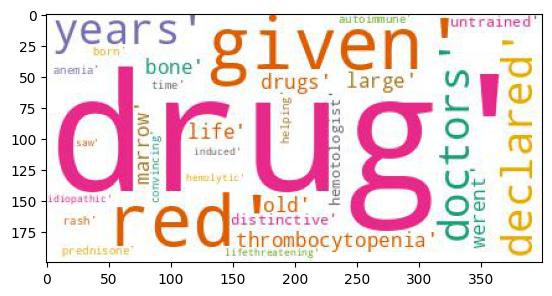

Average Rating of  : [1.0]


Found Useful To(persons) : [2]


List of other drugs also for Bacterial Infection: ['Keflex', 'Clindamycin', 'Metronidazole', 'Amoxicillin / clavulanate', 'Doxycycline', 'Flagyl', 'Cephalexin', 'Garlic', 'Cleocin', 'Vancomycin', 'Sulfamethoxazole / trimethoprim', 'Rocephin', 'Levofloxacin', 'Azithromycin', 'Amoxicillin', 'Avelox', 'Levaquin', 'Zyvox', 'Augmentin', 'Penicillin VK', 'Penicillin v potassium', 'Cipro', 'Moxifloxacin', 'Ceftin', 'Linezolid', 'Doxy 100', 'Cefuroxime', 'Ciprofloxacin', 'Bactrim DS', 'Ceftriaxone', 'Bactrim', 'Azithromycin Dose Pack']  


Best medication  based on Average rating : Garlic


best Medication by number of person(s) that found it useful: Clindamycin



In [87]:
print("Report on {0} for {1}".format(drugname,condition))
wcdata = combined_data.chunk[(combined_data.Condition == condition) & (combined_data.drugName==drugname)]
wc_topword= top_word[(condition,drugname)]
wc.generate(str(wc_topword))
wc.to_file('wc.jpeg')
plt.show
plt.show('wc.jpeg')
img = mpimg.imread('wc.jpeg')
imgplot = plt.imshow(img)
plt.show()
wc_topword= top_word[(condition,drugname)]
wc.generate(str(wc_topword))


'''
You can easily see a high correlation between  (Number of people
that found it useful and average rating) and positivity or negativity of
words found in the word cloud
'''
#Note that max rating is a 10.
realdata = data[['drugName', 'condition','rating','usefulCount']]
realdata = realdata[data.condition == condition]

alldrugs = combined_data[(combined_data.Condition == condition)]
requesteddrug = combined_data[(combined_data.Condition ==condition) & (combined_data.drugName == drugname)]
relateddrugs =  combined_data[(combined_data.Condition ==condition) & (combined_data.drugName != drugname)]
max_average_rating = list(alldrugs.drugName[alldrugs.averageRating == alldrugs.averageRating.max()])[0]
max_usefulTo =list(alldrugs.drugName[alldrugs.usefulTo == alldrugs.usefulTo.max()])[0]
#col1 = (alldrugs["usefulTo"]/100).astype(str)
#col2 = alldrugs["averageRating"].astype(str)
print("Average Rating of  : {0}\n".format(list(requesteddrug.averageRating))+'\n\n'+
"Found Useful To(persons) : {0}\n".format(list(requesteddrug.usefulTo))+'\n\n'+
"List of other drugs also for {1}: {0}  \n".format(list(relateddrugs.drugName.unique()),condition)+'\n\n'+
"Best medication  based on Average rating : {0}\n".format(max_average_rating)+'\n\n'+
"best Medication by number of person(s) that found it useful: {0}\n".format(max_usefulTo))

In [94]:
def wordcreator(issue,medication):
    wc = WordCloud(stopwords=stop_words, background_color='white',
                        colormap='Dark2', max_font_size=300, max_words=30, random_state=42)


In [99]:
issue = condition
medication= drugname

<ipython-input-117-8454e5076ff4>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alldrugs['Rank'] = (col2+col1).rank(method='dense', ascending=False).astype(int)


**************************************************
Report on Chloromycetin for Bacterial Infection
**************************************************
Word Cloud on Chloromycetin
--------------------------------------------------


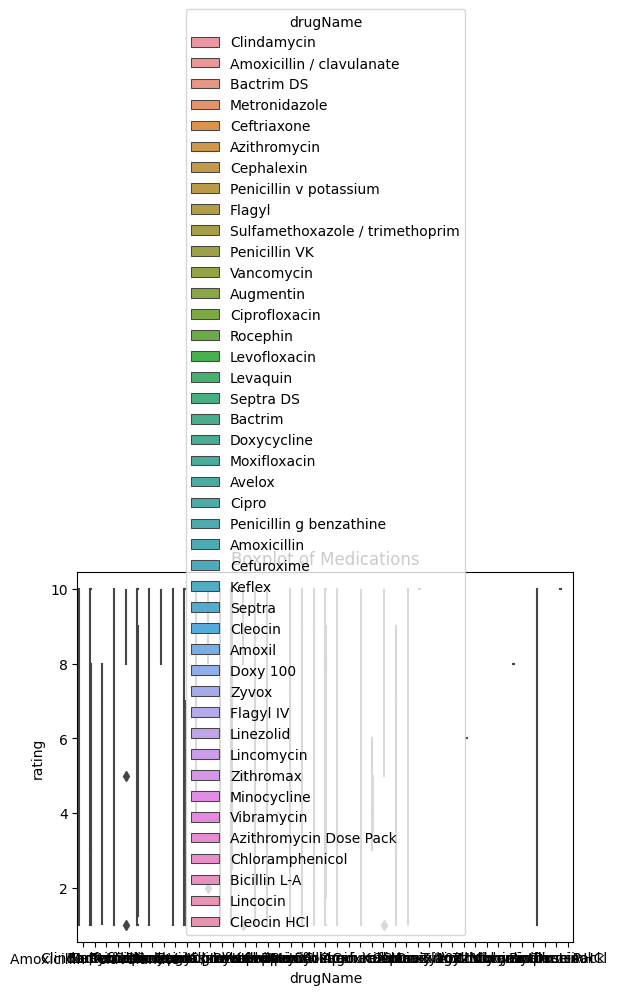

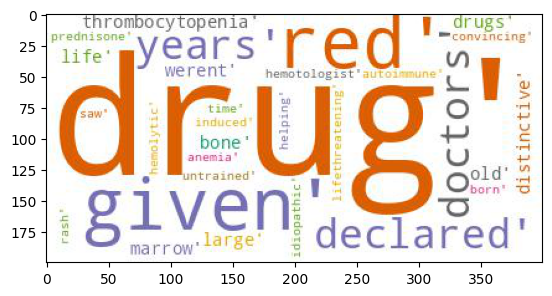

--------------------------------------------------
Statistics Summary on Chloromycetin
--------------------------------------------------
Average Rating of  : [1.0]
Found Useful To(persons) : [2]
--------------------------------------------------
Related Medication Others Used for Bacterial Infection
--------------------------------------------------
List of other drugs: ['Keflex', 'Clindamycin', 'Metronidazole', 'Amoxicillin / clavulanate', 'Doxycycline', 'Flagyl', 'Cephalexin', 'Garlic', 'Cleocin', 'Vancomycin', 'Sulfamethoxazole / trimethoprim', 'Rocephin', 'Levofloxacin', 'Azithromycin', 'Amoxicillin', 'Avelox', 'Levaquin', 'Zyvox', 'Augmentin', 'Penicillin VK', 'Penicillin v potassium', 'Cipro', 'Moxifloxacin', 'Ceftin', 'Linezolid', 'Doxy 100', 'Cefuroxime', 'Ciprofloxacin', 'Bactrim DS', 'Ceftriaxone', 'Bactrim', 'Azithromycin Dose Pack']
--------------------------------------------------
Word Cloud for other related Medications for Bacterial Infection
--------------------------

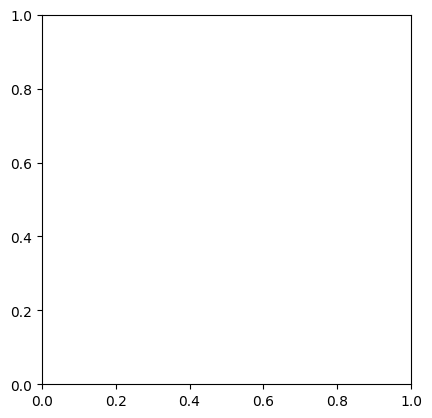

In [117]:
#original dataset that has not been summarised
realdata = data[['drugName', 'condition','rating','usefulCount']]
realdata = realdata[data.condition == condition]
ratingplot = sns.boxplot(x='drugName',y='rating',hue='drugName',data=realdata).set_title('Boxplot of Medications')

alldrugs = combined_data[(combined_data.Condition == condition)]
requesteddrug = combined_data[(combined_data.Condition ==condition) & (combined_data.drugName == drugname)]
relateddrugs =  combined_data[(combined_data.Condition ==condition) & (combined_data.drugName != drugname)]
max_average_rating = list(alldrugs.drugName[alldrugs.averageRating == alldrugs.averageRating.max()])[0]
max_usefulTo =list(alldrugs.drugName[alldrugs.usefulTo == alldrugs.usefulTo.max()])[0]
col1 = (alldrugs["usefulTo"]/100).astype(str)
col2 = alldrugs["averageRating"].astype(str)

alldrugs['Rank'] = (col2+col1).rank(method='dense', ascending=False).astype(int)
sorted_rank =alldrugs.sort_values('Rank')
sorted_rank = sorted_rank[['drugName','averageRating','usefulTo','Rank']]

alldrugs.drop(['Rank'],axis=1)



title = "Report on {0} for {1}".format(drugname,condition)
subtitle =['Word Cloud on {0}'.format(drugname),
            'Statistics Summary on {0}'.format(drugname),
            'Related Medication Others Used for {0}'.format(condition),
            'Word Cloud for other related Medications for {0}'.format(condition),
            'Summary Statistics of other related medications',
            'Best Medication for {0} according to reviews'.format(condition)]
message = ["Average Rating of  : {0}".format(list(requesteddrug.averageRating)),
            "Found Useful To(persons) : {0}".format(list(requesteddrug.usefulTo)),
            "List of other drugs: {0}".format(list(relateddrugs.drugName.unique())),
            #"Best Medication for {0} is {1}".format(condition,sorted_rank[0]),
            "Best medication  based on Average rating : {0}".format(max_average_rating),
            "best Medication by number of person(s) that found it useful: {0}".format(max_usefulTo)]
print("**************************************************")
print(title )
print("**************************************************")
print(subtitle[0])
print("--------------------------------------------------")

wcdata = combined_data.chunk[(combined_data.Condition == condition) & (combined_data.drugName==drugname)]
wc_topword= top_word[(condition,drugname)]
wc.generate(str(wc_topword))
wc.to_file('wc.jpeg')
plt.show
plt.show('wc.jpeg')
img = mpimg.imread('wc.jpeg')
imgplot = plt.imshow(img)
plt.show()
print("--------------------------------------------------")
print(subtitle[1])
print("--------------------------------------------------")
print(message[0])
print(message[1])
try:
  if (relateddrugs.empty !=True):
        print("--------------------------------------------------")
        print(subtitle[2])
        print("--------------------------------------------------")
        print(message[2])
        print("--------------------------------------------------")
        print(subtitle[3])
        print("--------------------------------------------------")
        unique_related_drug = list(relateddrugs.drugName.unique())
        for drug in unique_related_drug:
            t= top_word[(condition,drug)]
            wc.generate(str(t))
            wc.to_file('fig.jpeg')
            plt.imshow('fig.jpeg')
            print("figure: "+drug)

        print("--------------------------------------------------")
        print(subtitle[4])
        print("--------------------------------------------------")
        print(ratingplot)
        print("--------------------------------------------------")
        print(subtitle[5])
        print("--------------------------------------------------")
        print(message[3])
        print(message[4])
except:
    print("Something went wrong, {0} or {1} were not found in the dataset".format(condition,drugname))